# Project 4: Insurance Claim Prediction

**Course:** Machine Learning in Finance & Insurance (ETH Zurich, Fall 2025)

**Responsible:** Gabriele Visentin

**Write the names of all group members (max. 5 members)**:

- Lyuben Baltadzhiev
- Marcel Blagotinšek
- Melih Karaköse
- Tristan Þórðarson

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

TIPS: 
- target is claim frequency and not total number of claims
- handle the ylogy when y=0 correct and not by arbitrary threshold
- data standardization after the train test split and not before (data leakege)

The goal of this project is to implement and compare different models for insurance frequency claim prediction on real data from the French motor third party liability dataset (see file freMTPL2freq.csv), which comprises $m=678,007$ car insurance policies.

### Poisson GLM.

We first fit a Poisson Generalized Linear Model (GLM), which is commonly used for insurance frequency claim prediction.

Let $ClaimNb_i$ be the number of claims and $Exposure_i$ be the duration in years of the $i$-th policy. We want to predict the claim frequency $y_i = \frac{ClaimNb_i}{Exposure_i} $, given a training set of insurance policy features $D = \{(x_i, y_i) \in \mathbb{R}^d \times \mathbb{R}_{+}, 1 \le i \le m\}$.

Under the Poisson GLM we assume that $y_i \cdot Exposure_i \sim \text{Poisson}(\lambda_i \cdot Exposure_i)$ with mean parameter $\lambda_i$ of the form

$$\lambda_i = \exp(\langle\theta,x_i\rangle+\theta_0) \quad \text{(1)}$$

for some regression coefficients $(\theta,\theta_0)\in\mathbb{R}^{d}\times\mathbb{R}$ to be estimated. 

The model is fitted by minimizing the following loss (formally known as the exposure-weighted Poisson deviance):

$$L(D, \hat{\theta}) = \frac{1}{\sum_{i=1}^{m} Exposure_i} \sum_{i=1}^{m} Exposure_i \cdot \ell(\hat{\lambda}_i, y_i) \quad \text{(2)}$$

where $\hat{\lambda}_{i} = \exp(\langle\hat{\theta},x_{i}\rangle+\hat{\theta}_{0})$ is the estimate of each policy's mean frequency and

$$\ell(\hat{\lambda}, y) = 2 \left( \hat{\lambda} - y - y \log \hat{\lambda} + y \log y \right),$$

with the convention that $x \log(x) = 0$ if $x = 0$.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Question 1.a

(a) Perform a 90%-10% train-test split, fit a Poisson GLM, and report Mean Absolute Error (MAE), Mean Squared Error (MSE) and the loss $L$ on train and test sets.



In [7]:
# dataset csv
data = pd.read_csv('freMTPL2freq.csv', sep=';')
print(data.head())

# print some statistics
num_policies = len(data)
total_claims = data['ClaimNb'].sum()
avg_claims = data['ClaimNb'].mean()
claim_dist = data['ClaimNb'].value_counts().sort_index()
print(f"Total Policies: {num_policies}")
print(f"Total Claims:   {total_claims}")
print(f"Average Claims per Policy: {avg_claims:.4f}")

   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region   
0         4       9       23         100       B6  Regular     7887    R31  \
1         4       6       26         100       B6  Regular     2308    R31   
2         4       6       26         100       B6  Regular     2308    R31   
3         7       4       44          50       B6  Regular       37    R94   
4         5       2       29          90       B6  Regular      335    R91   

  Exposure  ClaimNb  
0     0,76        0  
1     0,74        0  
2     0,11        0  
3     0,83        0  
4     0,69        0  
Total Policies: 678007
Total Claims:   26383
Average Claims per Policy: 0.0389


In [8]:
# the decimal in the csv file is not with .
data['Exposure'] = data['Exposure'].str.replace(',', '.').astype(float)

# we checked for missing values but there are none so the dataset is tidy

# define target, offset, numerical and categorical cols
target_col = 'ClaimNb'
offset_col = 'Exposure'
category_cols = ['VehBrand', 'VehGas', 'Region']
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Train-test split
X = data.drop(columns=[target_col, offset_col])
y = data[target_col]
exposure = data[offset_col]

# split
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(X, y, exposure, test_size=0.1, random_state=0)

# we checked for missing values but there are none so the dataset is tidy

# copy before one-hot encoding
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# encode only categorical columns
X_train_enc = pd.get_dummies(X_train, columns=category_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=category_cols, drop_first=True)

# ensure test set has the exact same columns as train set
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# calculate statistics ONLY on the training data
train_means = X_train_enc[numerical_cols].mean()
train_stds  = X_train_enc[numerical_cols].std(ddof=1)
X_train_final = X_train_enc.copy()
X_test_final  = X_test_enc.copy()

# standardize
X_train_final[numerical_cols] = (X_train_final[numerical_cols] - train_means) / train_stds
X_test_final[numerical_cols]  = (X_test_final[numerical_cols]  - train_means) / train_stds

# Train a Poisson GLM

# target y_i = ClaimNb / Exposure
y_train_freq = y_train / exposure_train
y_test_freq = y_test / exposure_test

# Poisson GLM and fit the model 
glm = PoissonRegressor(alpha=0, fit_intercept=True, max_iter=1000)

# "Minimize the weighted Poisson deviance by passing the exposure feature as weight"
glm.fit(X_train_final, y_train_freq, sample_weight=exposure_train)

# Print MAE, MSE and loss on train and test data sets

# the model predicts the frequency rate directly
lambda_train_pred = glm.predict(X_train_final)
lambda_test_pred = glm.predict(X_test_final)

# convert rates to expected counts for MAE/MSE
y_train_pred_count = lambda_train_pred * exposure_train
y_test_pred_count = lambda_test_pred * exposure_test

# calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred_count)
mae_test = mean_absolute_error(y_test, y_test_pred_count)

mse_train = mean_squared_error(y_train, y_train_pred_count)
mse_test = mean_squared_error(y_test, y_test_pred_count)

# define the exposure weighted poisson deviance loss
def exposure_weighted_poisson_deviance_loss(lambda_hat, y_actual_counts, exposure):
    # calculate actual rate y = ClaimNb / Exposure
    y_true = y_actual_counts / exposure
    # log term when y > 0
    log_term = np.zeros_like(y_true)
    pos = y_true > 0
    # calculate the log term: y * log(y / lambda_hat)
    log_term[pos] = y_true[pos] * np.log(y_true[pos] / lambda_hat[pos])
    # deviance term
    deviance = 2 * (lambda_hat - y_true + log_term)
    # return exposure weighted average
    return np.average(deviance, weights=exposure)

# train and test loss
loss_train = exposure_weighted_poisson_deviance_loss(lambda_train_pred, y_train, exposure_train)
loss_test = exposure_weighted_poisson_deviance_loss(lambda_test_pred, y_test, exposure_test)

# metrics
print("\n" + "="*50)
print(f"{'METRIC':<15} | {'TRAIN SET':<15} | {'TEST SET':<15}")
print("="*50)
print(f"{'MAE':<15} | {mae_train:<15.6f} | {mae_test:<15.6f}")
print(f"{'MSE':<15} | {mse_train:<15.6f} | {mse_test:<15.6f}")
print(f"{'Loss (Dev)':<15} | {loss_train:<15.6f} | {loss_test:<15.6f}")
print("="*50)



METRIC          | TRAIN SET       | TEST SET       
MAE             | 0.072784        | 0.073235       
MSE             | 0.041037        | 0.040932       
Loss (Dev)      | 0.458025        | 0.460548       


Results show that our model is stable and not overfitting, as the training and test scores are nearly identical across all metrics, with the loss remaining consistent at around 0.460. The Mean Absolute Error of approximately 0.07 indicates that, on average, our predictions are very close to zero, which is expected since most insurance policies have no claims. Overall, this provides us with a good baseline model; any future models we build, such as those using feature engineering or neural networks, will need to achieve a loss lower than 0.4605 to be considered an improvement.

### Question 1.b

(b) Feature Engineering: Given the functional dependence in (1), it is often possible to improve the performance of a Poisson GLM model by transforming the dataset features. This procedure is known as feature engineering and requires performing exploratory data analysis.

For every feature in the data set, plot the empirical marginal log-frequencies:

$$x \mapsto \log\left(\frac{\sum_{i\in S(x)}ClaimNb_i}{\sum_{i\in S(x)}Exposure_i}\right)$$

where $S(x) := \{i \mid Feature_i = x\}$ and $x$ belongs to the range of $Feature$. To guarantee a good fit in (1), this dependence should be approximately linear. Propose feature transformations to improve the fit, for instance by non-linearly transforming a feature or by mapping a discrete feature into a categorical one. Justify your choices.



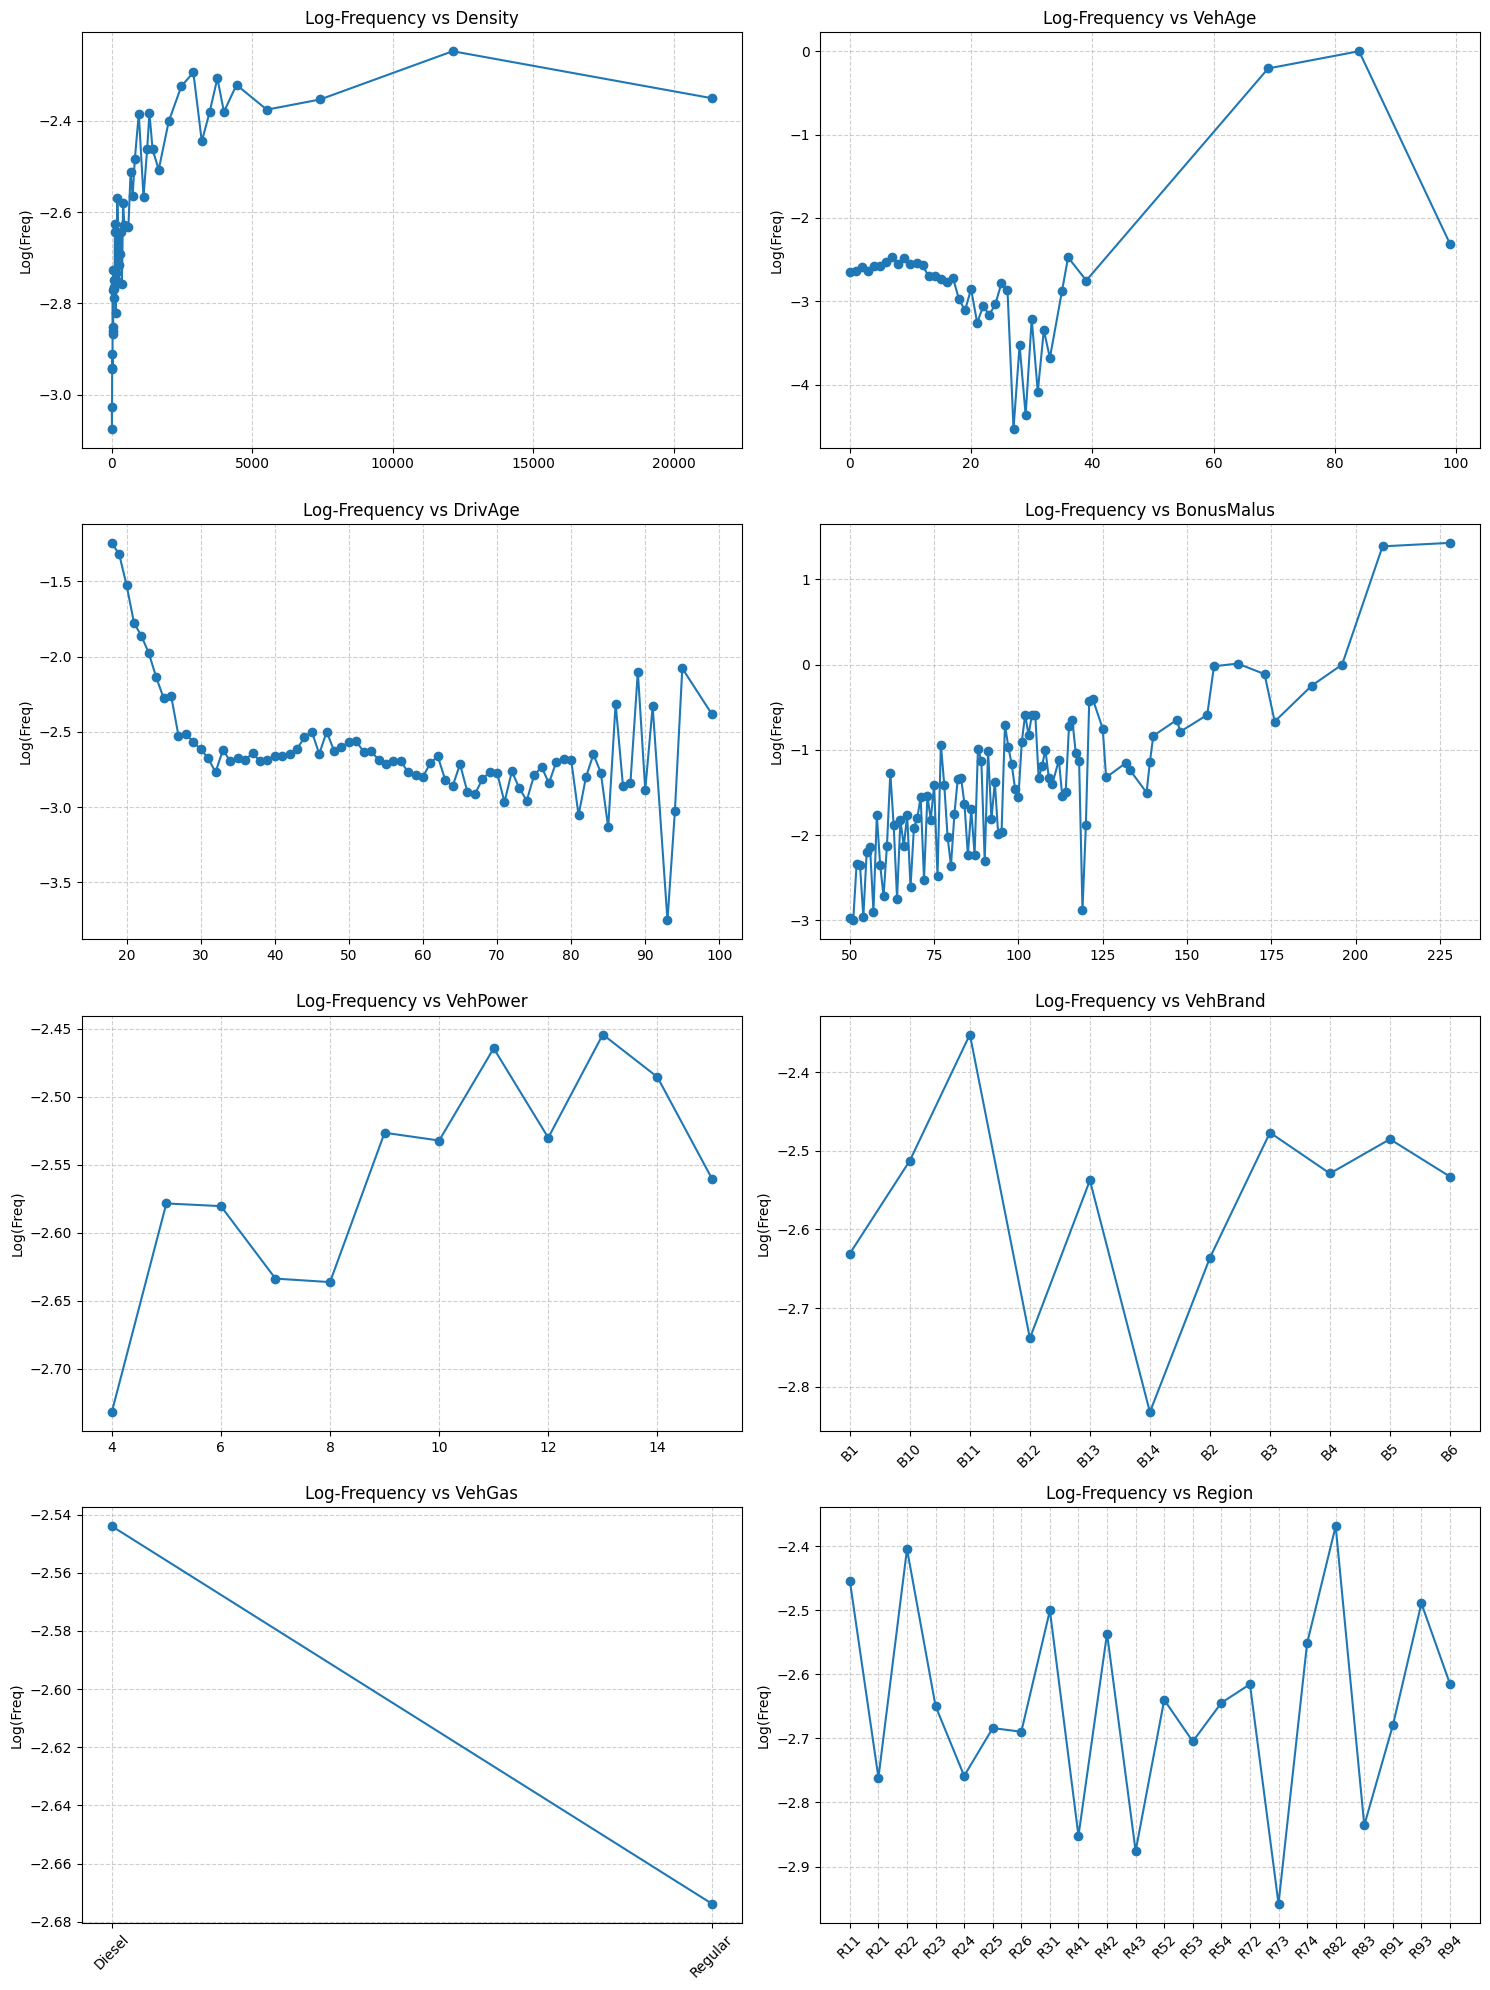

In [9]:
# Plot the empirical marginal log-frequencies
features = ['Density', 'VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'VehBrand', 'VehGas', 'Region']

# setup the figure
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
df_plot = X_train.copy()
df_plot['ClaimNb'] = y_train
df_plot['Exposure'] = exposure_train

for i, col in enumerate(features):
    ax = axes[i]
    
    if col == 'Density':
        #continuous 'Density'
        df_temp = df_plot[[col, 'ClaimNb', 'Exposure']].copy()
        df_temp['bin'] = pd.qcut(df_temp[col], q=50, duplicates='drop')
        
        grouped = df_temp.groupby('bin', observed=True)[['ClaimNb', 'Exposure']].sum()
        # mid-point of the bin for the x-axis
        grouped['x_val'] = grouped.index.map(lambda x: x.mid)
        
    else:
        # discrete/categorical, group by the value itself
        grouped = df_plot.groupby(col, observed=True)[['ClaimNb', 'Exposure']].sum()
        grouped['x_val'] = grouped.index

    # calculate Log-Frequency 
    grouped['Frequency'] = grouped['ClaimNb'] / grouped['Exposure']
    
    # filter out zero frequencies to avoid errors
    grouped = grouped[grouped['Frequency'] > 0].copy()
    grouped['LogFreq'] = np.log(grouped['Frequency'])
    
    #plot
    ax.plot(grouped['x_val'], grouped['LogFreq'], 'o-')
    ax.set_title(f'Log-Frequency vs {col}')
    ax.set_ylabel('Log(Freq)')
    ax.grid(True, linestyle='--', alpha=0.6)
    if col in ['VehBrand', 'VehGas', 'Region']:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

*CORRECT THIS AT THE END DEPENDING ON WHAT WE DECIDE TO DO*

**Density**
We see a sharp curve where risk drops quickly as density increases, which a straight line can't fit, so we will apply a log transformation. This should work because it compresses the massive range of density values into a smaller scale, making the relationship linear so our model can easily fit it.

**VehAge (Car Age)**
The plot shows risk falling steeply for new cars and then flattening out for older ones, so we will bin this feature into categories like "New," "Medium," and "Old." This should work because it allows the model to learn a specific risk level for new cars independent of old cars, rather than failing to fit a single straight line through a changing trend.

**DrivAge (Driver Age)**
We observe a "U-shape" where risk is massive for young drivers, drops for adults, and stabilizes for seniors, so we will bin the ages into groups (Young, Adult, Senior). This should work because it breaks the linear assumption, allowing the model to assign a heavy penalty specifically to young drivers without forcing that same trend onto older age groups.

**BonusMalus**
This plot is already a good straight line sloping upwards, meaning risk increases linearly with the score, so we will keep it as is. This should work because our Generalized Linear Model is built to understand this kind of linear line relationship.

**VehPower**
The line is noisy and goes up and down, showing higher power doesn't always mean higher risk, so we will treat this as a categorical feature. This should because it treats each power level as a unique label, allowing the model to learn the specific risk for "Power 6" versus "Power 7" without assuming one is  "bigger" than the other.

**Categorical Features (Brand, Gas, Region)**
For `VehBrand`, `VehGas`, and `Region`, we see distinct differences in risk levels between groups, so we will keep them as categorical features. This should work because one-hot encoding lets the model learn a specific "risk adjustment" for each individual brand or region code.

**Remark on VehPower**:
While we might expect accident risk to increase linearly with vehicle power, the data shows a non-monotonic relationship (e.g., Power 6 has higher risk than Power 7). This suggests that `VehPower` acts as a proxy for driver profile rather than just engine size. For instance, mid-range power vehicles might be preferred by younger, inexperienced drivers (high risk), while higher-powered sedans might be driven by more experienced, wealthier drivers (lower risk). Treating `VehPower` as categorical allows the model to capture these specific risk profiles without forcing an incorrect linear assumption.

In [ ]:
# 2. bin VehAge 0-15 (New), 15-100 (Medium), 100+ (Old) - if we decide to square the age we delete this
#veh_age_bins = [-1, 1, 15, 100]
#veh_age_labels = ['New', 'Medium', 'Old']

#X_train_eng['VehAge_Bin'] = pd.cut(X_train['VehAge'], bins=veh_age_bins, labels=veh_age_labels)
#X_test_eng['VehAge_Bin'] = pd.cut(X_test['VehAge'], bins=veh_age_bins, labels=veh_age_labels)
#X_train_eng = X_train_eng.drop(columns=['VehAge'])
#X_test_eng = X_test_eng.drop(columns=['VehAge'])


#new_num_cols = ['LogDensity', 'BonusMalus'] - if we decide to square the age we delete this
#new_num_cols = ['LogDensity', 'BonusMalus', 'VehAge', 'VehAge_Sq'] - if we decide to add the new young people in big cars vaiable

In [10]:
# we implement the proposed fetture engineering
# new copies
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# 1. log transform Density
X_train_eng['LogDensity'] = np.log(X_train['Density'])
X_test_eng['LogDensity'] = np.log(X_test['Density'])
X_train_eng = X_train_eng.drop(columns=['Density'])
X_test_eng = X_test_eng.drop(columns=['Density'])

# 2. VehAges square - no binnning
# We keep the linear term 'VehAge' and add the squared term 'VehAge_Sq'
X_train_eng['VehAge_Sq'] = X_train['VehAge'] ** 2
X_test_eng['VehAge_Sq'] = X_test['VehAge'] ** 2

# 3. Bin DrivAge bins: 18-21, 22-26, 27-31, 32-41, 42-51, 52-71, 71+
driv_age_bins = [17, 21, 26, 31, 41, 51, 71, 101]
driv_age_labels = ['18-21', '22-26', '27-31', '32-41', '42-51', '52-71', '71+']

X_train_eng['DrivAge_Bin'] = pd.cut(X_train['DrivAge'], bins=driv_age_bins, labels=driv_age_labels)
X_test_eng['DrivAge_Bin'] = pd.cut(X_test['DrivAge'], bins=driv_age_bins, labels=driv_age_labels)
X_train_eng = X_train_eng.drop(columns=['DrivAge'])
X_test_eng = X_test_eng.drop(columns=['DrivAge'])

#test if this has any sense, because in reality younger drivers are most dangerous in big machine cars
X_train_eng['Young_HighPower'] = ((X_train['DrivAge'] <= 25) & (X_train['VehPower'] >= 9)).astype(int)
X_test_eng['Young_HighPower'] = ((X_test['DrivAge'] <= 25) & (X_test['VehPower'] >= 9)).astype(int)

# 4. VehPower to Categorical
X_train_eng['VehPower'] = X_train['VehPower'].astype(str)
X_test_eng['VehPower'] = X_test['VehPower'].astype(str)

# new list of categorical columns for onehot encoding
#new_cat_cols = ['VehBrand', 'VehGas', 'Region', 'VehAge_Bin', 'DrivAge_Bin', 'VehPower'] - if we decide to square the age we delete this
new_cat_cols = ['VehBrand', 'VehGas', 'Region', 'DrivAge_Bin', 'VehPower']

X_train_enc = pd.get_dummies(X_train_eng, columns=new_cat_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test_eng, columns=new_cat_cols, drop_first=True)

# ensure test set has same columns as train set
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# new numerical cols

new_num_cols = ['LogDensity', 'BonusMalus', 'VehAge', 'VehAge_Sq', 'Young_HighPower']

# standardize
train_means = X_train_enc[new_num_cols].mean()
train_stds = X_train_enc[new_num_cols].std(ddof=1)
X_train_new = X_train_enc.copy()
X_test_new = X_test_enc.copy()
X_train_new[new_num_cols] = (X_train_new[new_num_cols] - train_means) / train_stds
X_test_new[new_num_cols] = (X_test_new[new_num_cols] - train_means) / train_stds

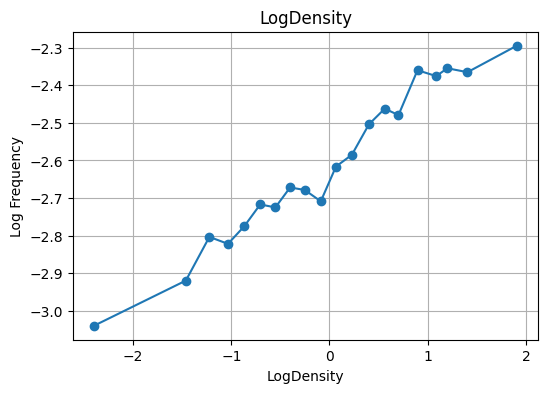

In [11]:
# short plot for confirming if we did anything
df = pd.DataFrame({'LogDensity': X_train_new['LogDensity'], 'ClaimNb': y_train, 'Exposure': exposure_train})
df['bin'] = pd.qcut(df['LogDensity'], 20, duplicates='drop') 
grouped = df.groupby('bin', observed=True)[['ClaimNb', 'Exposure']].sum()
log_freq = np.log(grouped['ClaimNb'] / grouped['Exposure'])

plt.figure(figsize=(6, 4))
plt.plot(grouped.index.map(lambda x: x.mid), log_freq, 'o-')
plt.title("LogDensity"); plt.xlabel("LogDensity"); plt.ylabel("Log Frequency")
plt.grid(True); plt.show()

The plot now shows a linear trend, confirming that the log transformation was the right choice for linear model.

### Question 1.c

(c) Fit a new Poisson GLM model on the same training set from (a) using the feature transformations you found in (b) and show that the model performance improves.

In [12]:
# Train a Poisson GLM using your feature transformations
glm_eng = PoissonRegressor(alpha=0, fit_intercept=True, max_iter=1000)
glm_eng.fit(X_train_new, y_train / exposure_train, sample_weight=exposure_train)

# make predictions
lambda_train_pred_new = glm_eng.predict(X_train_new)
lambda_test_pred_new = glm_eng.predict(X_test_new)

# Print MAE, MSE and loss on train and test data sets
y_train_pred_count_new = lambda_train_pred_new * exposure_train
y_test_pred_count_new = lambda_test_pred_new * exposure_test

mae_train_new = mean_absolute_error(y_train, y_train_pred_count_new)
mae_test_new = mean_absolute_error(y_test, y_test_pred_count_new)
mse_train_new = mean_squared_error(y_train, y_train_pred_count_new)
mse_test_new = mean_squared_error(y_test, y_test_pred_count_new)

# caclulate weighted poisson deviance loss
loss_train_new = exposure_weighted_poisson_deviance_loss(lambda_train_pred_new, y_train, exposure_train)
loss_test_new = exposure_weighted_poisson_deviance_loss(lambda_test_pred_new, y_test, exposure_test)

# Make sure your model outperforms the model of Question 1.a
print("\n" + "="*70)
print(f"{'METRIC':<15} | {'BASELINE (Task 1a)':<22} | {'IMPROVED (Task 1c)':<22}")
print("="*70)

# comparing against the old variables (mae_test, mse_test, loss_test) from Task 1a
print(f"{'MAE (Test)':<15} | {mae_test:<22.6f} | {mae_test_new:<22.6f}")
print(f"{'MSE (Test)':<15} | {mse_test:<22.6f} | {mse_test_new:<22.6f}")
print(f"{'Loss (Dev)':<15} | {loss_test:<22.6f} | {loss_test_new:<22.6f}")
print("="*70)


METRIC          | BASELINE (Task 1a)     | IMPROVED (Task 1c)    
MAE (Test)      | 0.073235               | 0.073133              
MSE (Test)      | 0.040932               | 0.040852              
Loss (Dev)      | 0.460548               | 0.458377              


We tried to improve our Poisson model by changing how the data looks so the model could learn from it easier. First, we transformed the Population Density using a logarithm because the original data was very skewed, and this made the relationship with accidents look more like a straight line. For the Car Age, instead of cutting it into separate groups, we added a "squared" version of the age. This allows the model to draw a smooth curve for risk as cars get older, rather than forcing a straight line or blocky steps. We also grouped Driver Age into standard ranges because risk is very high for young drivers and drops quickly, which is a pattern a simple line cannot fit. Finally, we treated Vehicle Power as categories because higher power didn't always mean higher risk in a consistent way.

We also tested a specific theory that young drivers in powerful cars are dangerous in a unique way. We created a special feature that flags drivers who are 25 or younger driving cars with high power (level 9 or above). We hoped this would help the model see that this specific combination adds extra risk that looking at Age and Power separately might miss.

The results show that these changes worked. Our new model achieved a Loss of roughly 0.45838, which is lower than our original baseline of 0.46055. We also saw similar small improvements in the Mean Absolute Error (MAE), which dropped from 0.07324 to 0.07314, and the Mean Squared Error (MSE), which decreased from 0.04093 to 0.04085. The drops are small but nonetheless we have imporoved our model.

# Exercise 2 (Poisson FNN)

TIPS: 
- target is claim frequency and not total number of claims
- handle the ylogy when y=0 correctly and not by arbitrary threshold
- we need to have sufficient performance on the neural network model
- incomplete training of the neural network model is penalized

We can achieve an even better performance by estimating the mean parameter in (1) using a feedforward neural network. When using a neural network, the model performs automatic feature engineering. You can implement the neural network using either PyTorch or TensorFlow.

### Question 2.a

**(a)** Implement a feedforward neural network $\tilde{\lambda}=F_{\theta}(x)$ with exponential activation $x\mapsto \exp(x)$ in the output layer. You should experiment with different network architectures and hyperparameters, until you find a network that performs well. You can start with two hidden layers of 20 neurons each with ReLU activation function and train for 100 epochs with batch size 10,000 and learning rate 0.01.

In [13]:
exposure_train

395062    0.54
139284    0.28
366822    0.21
309193    0.32
297918    1.00
          ... 
359783    0.20
152315    1.00
117952    1.00
435829    0.90
305711    0.28
Name: Exposure, Length: 610206, dtype: float64

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import itertools as it

from tqdm.notebook import tqdm

# Neural network implementation
X_train_nn = torch.tensor(X_train_final.astype(float).values, dtype=torch.float32)
X_test_nn = torch.tensor(X_test_final.astype(float).values, dtype=torch.float32)
y_train_nn = torch.tensor(y_train.astype(float).values, dtype=torch.float32)
y_test_nn = torch.tensor(y_test.astype(float).values, dtype=torch.float32)
exposure_train_nn = torch.tensor(exposure_train.astype(float).values, dtype=torch.float32)
exposure_test_nn = torch.tensor(exposure_test.astype(float).values, dtype=torch.float32)

def exposure_weighted_poisson_deviance_loss_nn(lambda_hat, y_actual_counts, exposure):
    # calculate actual rate y = ClaimNb / Exposure
    y_true = y_actual_counts / exposure
    # log term when y > 0
    log_term = torch.zeros_like(y_true)
    pos = y_true > 0
    # calculate the log term: y * log(y / lambda_hat)
    log_term[pos] = y_true[pos] * torch.log(y_true[pos] / lambda_hat[pos].flatten())
    # deviance term
    deviance = 2 * (lambda_hat.flatten() - y_true + log_term)
    return (torch.sum(deviance*exposure) / torch.sum(exposure))

class ExponentialActivation(nn.Module):
    def __init__(self):
        super(ExponentialActivation, self).__init__()

    def forward(self, x):
        return torch.exp(x)

nh1 = 64 # first hidden layer
nh2 = 64 # second hidden layer
InputDim = X_train_nn.shape[1] # input layer
OutputDim = 1 # output layer


# network = nn.Sequential(nn.Linear(InputDim, nh1),
#                         nn.Tanh(),
#                         nn.Linear(nh1, nh2),
#                         nn.Tanh(),
#                         nn.Linear(nh1, nh2),
#                         nn.Tanh(),
#                         nn.Linear(nh1, nh2),
#                         nn.Tanh(),
#                         nn.Linear(nh2, OutputDim),
#                         ExponentialActivation())



network = nn.Sequential(nn.Linear(InputDim, nh1),
                        nn.ReLU(),
                        nn.Linear(nh1, nh2),
                        nn.ReLU(),
                        nn.Linear(nh2, OutputDim),
                        ExponentialActivation())



In [33]:
# Define training hyperparameters
n_epochs = 100
lr = 1e-4
batch_size = 10000
# milestones = [75]
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

dataset = TensorDataset(X_train_nn, y_train_nn, exposure_train_nn)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = torch.empty(n_epochs)
training_loop = tqdm(range(n_epochs))

for epoch in training_loop:
    # At each epoch iterate over batches
    for x, y, exposure in loader:
        loss = (
                exposure_weighted_poisson_deviance_loss_nn(network(x), y, exposure)
            )

        # compute gradient of training loss wrt parameters
        loss.backward()
        # do one gradient step
        optimizer.step()
        # reset the computational graph        
        optimizer.zero_grad()
        
    
    # Print loss in the progression bar
    training_loop.set_postfix(loss = loss.item())
    
    # decrease learning rate according to scheduler's settings
    # scheduler.step()

    # save training loss for plotting
    losses[epoch] = loss.item()

  0%|          | 0/100 [00:00<?, ?it/s]

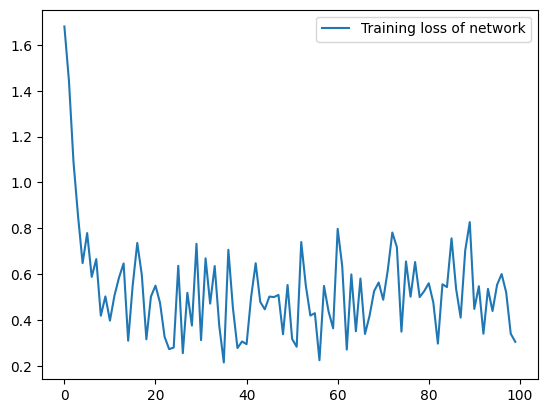

In [34]:
plt.plot(losses, label='Training loss of network')
plt.legend()
plt.show()

In [36]:
exposure_weighted_poisson_deviance_loss_nn(network(X_train_nn), y_train_nn, exposure_train_nn).item()

0.45312434434890747

In [37]:
lambda_train_pred_nn = network(X_train_nn).flatten().detach().numpy()
lambda_test_pred_nn = network(X_test_nn).flatten().detach().numpy()

y_train_pred_count_nn = lambda_train_pred_nn * exposure_train
y_test_pred_count_nn = lambda_test_pred_nn * exposure_test

mae_train_nn = mean_absolute_error(y_train, y_train_pred_count_nn)
mae_test_nn = mean_absolute_error(y_test, y_test_pred_count_nn)
mse_train_nn = mean_squared_error(y_train, y_train_pred_count_nn)
mse_test_nn = mean_squared_error(y_test, y_test_pred_count_nn)

#caclulate weighted poisson deviance loss
loss_train_nn = exposure_weighted_poisson_deviance_loss(lambda_train_pred_nn, y_train, exposure_train)
loss_test_nn = exposure_weighted_poisson_deviance_loss(lambda_test_pred_nn, y_test, exposure_test)

# Make sure your model outperforms the model of Question 1.a
print("\n" + "="*70)
print(f"{'METRIC':<15} | {'BASELINE (Task 1c)':<22} | {'IMPROVED (Task 2b)':<22}")
print("="*70)

# comparing against the old variables (mae_test, mse_test, loss_test) from Task 1a
print(f"{'MAE (Test)':<15} | {mae_test_new:<22.6f} | {mae_test_nn:<22.6f}")
print(f"{'MSE (Test)':<15} | {mse_test_new:<22.6f} | {mse_test_nn:<22.6f}")
print(f"{'Loss (Dev)':<15} | {loss_test_new:<22.6f} | {loss_test_nn:<22.6f}")
print("="*70)


METRIC          | BASELINE (Task 1c)     | IMPROVED (Task 2b)    
MAE (Test)      | 0.073133               | 0.072489              
MSE (Test)      | 0.040852               | 0.040758              
Loss (Dev)      | 0.458377               | 0.457495              


### Question 2.b

**(b)** Train the model on the training set of Exercise 1(a) by minimizing the loss $\mathcal{L}$ in Equation (2). Report MAE, MSE and the loss $\mathcal{L}$ on train and test sets and show that the model outperforms the Poisson GLM from Exercise 1(c).

**Remark:** Try different regularization techniques, such as $L^2$ regularization. Remember to justify your choice of the regularization hyperparameter(s) by cross-validation.

In [ ]:
# Train Poisson feedforward neural network model

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the Poisson GLM model of Question 1.b.

# Exercise 3 (Tree-based methods)

TIPS: 
- target is claim frequency and not total number of claims
- handle the ylogy when y=0 correctl and not by arbitrary threshold
- the optimal hyperparameters for all models a b and c cannot be at the edge of the cross validation grid
- in all a b and c we have to report best hyper parameters from cross validation

Implement and compare the following tree-based methods (You may use the implementations in the libraries 'sklearn.tree' and 'sklearn.ensemble'.) on the training set of Exercise 1(a). Train each model by minimizing the weighted Poisson deviance in Equation (2) and report the MAE, MSE and weighted Poisson deviance on train and test sets.

### Question 3.a

(a) Implement a regression tree and optimize the model performance by cross-validating on the minimum impurity decrease.

In [23]:
# Question 3.a - Regression tree with cross-validation on min_impurity_decrease

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# use claim frequency as target
y_train_freq = y_train / exposure_train
y_test_freq = y_test / exposure_test

X_train_tree = X_train_final.copy()
X_test_tree = X_test_final.copy()

# define model and hyperparameter grid
tree = DecisionTreeRegressor(criterion='poisson',random_state=0)

param_grid_tree = {
    "min_impurity_decrease": [0.0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

grid_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_tree,
    cv=3,
    scoring="neg_mean_poisson_deviance",
    n_jobs=-1,
)

# cross-validation (weight by exposure)
grid_tree.fit(X_train_tree, y_train_freq, sample_weight=exposure_train)

best_tree = grid_tree.best_estimator_
print("Best parameters (Regression tree):", grid_tree.best_params_)

# predictions in frequency space
lambda_train_pred_tree = best_tree.predict(X_train_tree)
lambda_test_pred_tree = best_tree.predict(X_test_tree)

# make sure frequencies are positive for Poisson deviance
lambda_train_pred_tree = np.clip(lambda_train_pred_tree, 1e-8, None)
lambda_test_pred_tree = np.clip(lambda_test_pred_tree, 1e-8, None)

# convert back to counts for MAE / MSE
y_train_pred_count_tree = lambda_train_pred_tree * exposure_train
y_test_pred_count_tree = lambda_test_pred_tree * exposure_test

# metrics
mae_train_tree = mean_absolute_error(y_train, y_train_pred_count_tree)
mae_test_tree = mean_absolute_error(y_test, y_test_pred_count_tree)

mse_train_tree = mean_squared_error(y_train, y_train_pred_count_tree)
mse_test_tree = mean_squared_error(y_test, y_test_pred_count_tree)

loss_train_tree = exposure_weighted_poisson_deviance_loss(
    lambda_train_pred_tree, y_train, exposure_train
)
loss_test_tree = exposure_weighted_poisson_deviance_loss(
    lambda_test_pred_tree, y_test, exposure_test
)

print("\n" + "=" * 70)
print(f"{'Regression tree':^70}")
print("=" * 70)
print(f"{'METRIC':<15} | {'TRAIN SET':>12} | {'TEST SET':>12}")
print("-" * 70)
print(f"{'MAE':<15} | {mae_train_tree:12.6f} | {mae_test_tree:12.6f}")
print(f"{'MSE':<15} | {mse_train_tree:12.6f} | {mse_test_tree:12.6f}")
print(f"{'Loss (Dev)':<15} | {loss_train_tree:12.6f} | {loss_test_tree:12.6f}")
print("=" * 70)


Best parameters (Regression tree): {'min_impurity_decrease': 0.0001}

                           Regression tree                            
METRIC          |    TRAIN SET |     TEST SET
----------------------------------------------------------------------
MAE             |     0.072236 |     0.072754
MSE             |     0.040640 |     0.040639
Loss (Dev)      |     0.452787 |     0.456746


### Question 3.b

(b) Implement a random forest regression and optimize the model performance by cross-validating on the minimum impurity decrease and the number of features to consider when looking for the best split.

In [31]:
# Question 3.b - Random forest with cross-validation on min_impurity_decrease and max_features

from sklearn.ensemble import RandomForestRegressor

X_train_rf = X_train_final.copy()
X_test_rf = X_test_final.copy()

rf = RandomForestRegressor(
    n_estimators=50,
    criterion='poisson',
    random_state=0,
    n_jobs=-1,
)

param_grid_rf = {
    "min_impurity_decrease": [0.0, 1e-8, 1e-7, 1e-6],
    "max_features": [0.3, 0.6, 0.9],
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="neg_mean_poisson_deviance",
    n_jobs=-1,
)

# cross-validation (weight by exposure)
grid_rf.fit(X_train_rf, y_train_freq, sample_weight=exposure_train)

best_rf = grid_rf.best_estimator_
print("Best parameters (Random forest):", grid_rf.best_params_)

# predictions in frequency space
lambda_train_pred_rf = best_rf.predict(X_train_rf)
lambda_test_pred_rf = best_rf.predict(X_test_rf)

lambda_train_pred_rf = np.clip(lambda_train_pred_rf, 1e-8, None)
lambda_test_pred_rf = np.clip(lambda_test_pred_rf, 1e-8, None)

# convert back to counts
y_train_pred_count_rf = lambda_train_pred_rf * exposure_train
y_test_pred_count_rf = lambda_test_pred_rf * exposure_test

# metrics
mae_train_rf = mean_absolute_error(y_train, y_train_pred_count_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_count_rf)

mse_train_rf = mean_squared_error(y_train, y_train_pred_count_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_count_rf)

loss_train_rf = exposure_weighted_poisson_deviance_loss(
    lambda_train_pred_rf, y_train, exposure_train
)
loss_test_rf = exposure_weighted_poisson_deviance_loss(
    lambda_test_pred_rf, y_test, exposure_test
)

print("\n" + "=" * 70)
print(f"{'Random forest':^70}")
print("=" * 70)
print(f"{'METRIC':<15} | {'TRAIN SET':>12} | {'TEST SET':>12}")
print("-" * 70)
print(f"{'MAE':<15} | {mae_train_rf:12.6f} | {mae_test_rf:12.6f}")
print(f"{'MSE':<15} | {mse_train_rf:12.6f} | {mse_test_rf:12.6f}")
print(f"{'Loss (Dev)':<15} | {loss_train_rf:12.6f} | {loss_test_rf:12.6f}")
print("=" * 70)


Best parameters (Random forest): {'max_features': 0.3, 'min_impurity_decrease': 1e-06}

                            Random forest                             
METRIC          |    TRAIN SET |     TEST SET
----------------------------------------------------------------------
MAE             |     0.065937 |     0.077297
MSE             |     0.034645 |     0.049924
Loss (Dev)      |     0.303613 |     0.475117


### Question 3.c

(c) Implement gradient boosted trees and optimize the model performance by cross-validating on the shrinkage parameter and the number of boosting steps.

In [29]:
# Question 3.c - Gradient boosted trees with cross-validation on learning_rate and n_estimators

from sklearn.ensemble import HistGradientBoostingRegressor

X_train_gb = X_train_final.copy()
X_test_gb = X_test_final.copy()

gb = HistGradientBoostingRegressor(
    loss='poisson',
    random_state=0,
)

param_grid_gb = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [50, 100, 200],
}

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=3,
    error_score='raise',
    scoring="neg_mean_poisson_deviance",
    n_jobs=-1,
)

# cross-validation (weight by exposure)
grid_gb.fit(X_train_gb, y_train_freq, sample_weight=exposure_train)

best_gb = grid_gb.best_estimator_
print("Best parameters (Gradient boosted trees):", grid_gb.best_params_)

# predictions in frequency space
lambda_train_pred_gb = best_gb.predict(X_train_gb)
lambda_test_pred_gb = best_gb.predict(X_test_gb)

lambda_train_pred_gb = np.clip(lambda_train_pred_gb, 1e-8, None)
lambda_test_pred_gb = np.clip(lambda_test_pred_gb, 1e-8, None)

# convert back to counts
y_train_pred_count_gb = lambda_train_pred_gb * exposure_train
y_test_pred_count_gb = lambda_test_pred_gb * exposure_test

# metrics
mae_train_gb = mean_absolute_error(y_train, y_train_pred_count_gb)
mae_test_gb = mean_absolute_error(y_test, y_test_pred_count_gb)

mse_train_gb = mean_squared_error(y_train, y_train_pred_count_gb)
mse_test_gb = mean_squared_error(y_test, y_test_pred_count_gb)

loss_train_gb = exposure_weighted_poisson_deviance_loss(
    lambda_train_pred_gb, y_train, exposure_train
)
loss_test_gb = exposure_weighted_poisson_deviance_loss(
    lambda_test_pred_gb, y_test, exposure_test
)

print("\n" + "=" * 70)
print(f"{'Gradient boosted trees':^70}")
print("=" * 70)
print(f"{'METRIC':<15} | {'TRAIN SET':>12} | {'TEST SET':>12}")
print("-" * 70)
print(f"{'MAE':<15} | {mae_train_gb:12.6f} | {mae_test_gb:12.6f}")
print(f"{'MSE':<15} | {mse_train_gb:12.6f} | {mse_test_gb:12.6f}")
print(f"{'Loss (Dev)':<15} | {loss_train_gb:12.6f} | {loss_test_gb:12.6f}")
print("=" * 70)


Best parameters (Gradient boosted trees): {'learning_rate': 0.05, 'max_iter': 100}

                        Gradient boosted trees                        
METRIC          |    TRAIN SET |     TEST SET
----------------------------------------------------------------------
MAE             |     0.071686 |     0.072411
MSE             |     0.040070 |     0.040309
Loss (Dev)      |     0.439875 |     0.449544
